In [19]:
import numpy as np

class ActivationFunction:
    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return z > 0

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(z):
        sig = ActivationFunction.sigmoid(z)
        return sig * (1 - sig)

class Normalization:
    @staticmethod
    def standardize(X):
        mean = np.mean(X, axis=1, keepdims=True)
        std = np.std(X, axis=1, keepdims=True)
        epsilon = 1e-8  # Small epsilon value to prevent division by zero
        X_standardized = (X - mean) / (std + epsilon)
        return X_standardized

class MiniBatch:
    @staticmethod
    def create_batches(X, Y, batch_size):
        m = X.shape[1]
        mini_batches = []

        # Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        # Partition (except the last mini-batch)
        num_complete_minibatches = m // batch_size
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k*batch_size : (k+1)*batch_size]
            mini_batch_Y = shuffled_Y[:, k*batch_size : (k+1)*batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < batch_size)
        if m % batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches*batch_size:]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches*batch_size:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

class Dropout:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def apply(self, A):
        self.mask = np.random.rand(*A.shape) > self.rate
        return A * self.mask / (1.0 - self.rate)

    def backward_apply(self, dA):
        return dA * self.mask / (1.0 - self.rate)

class Regularization:
    @staticmethod
    def l2(lambda_, weights):
        return lambda_ * np.sum(np.square(weights))

    @staticmethod
    def l1(lambda_, weights):
        return lambda_ * np.sum(np.abs(weights))

class Parameters:
    def __init__(self, learning_rate=0.01, regularization=None, lambda_=0.01, dropout_rate=0.0):
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.lambda_ = lambda_
        self.dropout_rate = dropout_rate

class Neuron:
    def __init__(self):
        self.aggregate_signal = None
        self.activation_output = None

    def activate(self, weighted_input, activation):
        if activation == "relu":
            self.activation_output = ActivationFunction.relu(weighted_input)
        elif activation == "sigmoid":
            self.activation_output = ActivationFunction.sigmoid(weighted_input)
        self.aggregate_signal = weighted_input

class LossFunction:
    @staticmethod
    def binary_crossentropy(Y, Y_hat):
        epsilon = 1e-15  # A small number to prevent log(0)
        Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)  
        m = Y.shape[1]
        cost = -1/m * np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
        return np.squeeze(cost)

    @staticmethod
    def mse(Y, Y_hat):
        m = Y.shape[1]
        cost = (1/m) * np.sum((Y - Y_hat)**2)
        return np.squeeze(cost)

    @staticmethod
    def rmse(Y, Y_hat):
        return np.sqrt(LossFunction.mse(Y, Y_hat))

    @staticmethod
    def compute_loss_derivative(Y, Y_hat, loss_function):
        epsilon = 1e-15  # A small number to prevent division by zero
        Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)  # Clip values to avoid division by zero
        if loss_function == "binary_crossentropy":
            return - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        elif loss_function == "mse":
            return 2 * (Y_hat - Y) / Y.size

class GradientDescent:
    @staticmethod
    def update_parameters(layers, learning_rate):
        for layer in layers:
            layer.weights -= learning_rate * layer.dW
            layer.bias -= learning_rate * layer.db


class Layer:
    def __init__(self, n_input, n_neurons, activation=None):
        self.weights = np.random.randn(n_neurons, n_input) * 0.01
        self.bias = np.zeros((n_neurons, 1))
        self.activation = activation
        self.neurons = [Neuron() for _ in range(n_neurons)]
        self.activation_output = None 

    def forward(self, A_prev):
        Z = np.dot(self.weights, A_prev) + self.bias
        A = np.zeros(Z.shape)

        for i, neuron in enumerate(self.neurons):
            neuron.activate(Z[i], self.activation)
            A[i] = neuron.activation_output

        self.activation_output = A  # Store the activation output
        return A

    def backward(self, dA, A_prev):
        m = A_prev.shape[1]
        dZ = np.zeros(dA.shape)

        if self.activation == "relu":
            for i, neuron in enumerate(self.neurons):
                dZ[i] = dA[i] * ActivationFunction.relu_derivative(neuron.aggregate_signal)
        elif self.activation == "sigmoid":
            for i, neuron in enumerate(self.neurons):
                dZ[i] = dA[i] * ActivationFunction.sigmoid_derivative(neuron.aggregate_signal)

        self.dW = np.dot(dZ, A_prev.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(self.weights.T, dZ)
        return dA_prev

    def update_parameters(self, learning_rate):
        self.weights -= learning_rate * self.dW
        self.bias -= learning_rate * self.db

class ForwardPropagation:
    @staticmethod
    def apply(layers, input_data):
        A = input_data
        for layer in layers:
            A = layer.forward(A)
        return A

class BackwardPropagation:
    @staticmethod
    def apply(layers, Y, Y_hat, input_data, loss_function_name):
        dA = LossFunction.compute_loss_derivative(Y, Y_hat, loss_function_name)
        for i in reversed(range(len(layers))):
            layer = layers[i]
            prev_A = layers[i-1].activation_output if i > 0 else input_data
            dA = layer.backward(dA, prev_A)


class Model:
    def __init__(self):
        self.layers = []
        self.loss_function_name = None
        self.loss_function = None

    def add(self, layer):
        self.layers.append(layer)

    def compile(self, loss_function):
        self.loss_function_name = loss_function
        if loss_function in ["binary_crossentropy", "mse", "rmse"]:
            self.loss_function = loss_function
        else:
            raise ValueError(f"Unsupported loss function: {loss_function}")

    def forward_propagation(self, X):
        return ForwardPropagation.apply(self.layers, X)

    def compute_cost(self, Y, Y_hat):
        if self.loss_function == "binary_crossentropy":
            return LossFunction.binary_crossentropy(Y, Y_hat)
        elif self.loss_function == "mse":
            return LossFunction.mse(Y, Y_hat)
        elif self.loss_function == "rmse":
            return LossFunction.rmse(Y, Y_hat)
        else:
            raise ValueError("Unsupported loss function")

    def backward_propagation(self, Y, Y_hat, input_data):
        BackwardPropagation.apply(self.layers, Y, Y_hat, input_data, self.loss_function_name)


    def update_parameters(self, learning_rate=0.01):
        GradientDescent.update_parameters(self.layers, learning_rate)


In [20]:
import matplotlib.pyplot as plt
class Train:
    def __init__(self, model, X_train, Y_train, X_val, Y_val, learning_rate=0.01, epochs=50, batch_size=64, normalize=False):
        self.model = model
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val  # Validation data
        self.Y_val = Y_val  # Validation labels
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.normalize = normalize

    def execute(self):
        if self.normalize:
            self.X_train = Normalization.standardize(self.X_train)

        # Initialize lists to store the loss and accuracy for each epoch
        self.epoch_losses = []
        self.epoch_accuracies = []

        for epoch in range(self.epochs):
            mini_batches = MiniBatch.create_batches(self.X_train, self.Y_train, self.batch_size)
            cost_total = 0

            for mini_batch in mini_batches:
                (mini_batch_X, mini_batch_Y) = mini_batch
                Y_hat = self.model.forward_propagation(mini_batch_X)
                cost_total += self.model.compute_cost(mini_batch_Y, Y_hat)
                self.model.backward_propagation(mini_batch_Y, Y_hat, mini_batch_X)
                self.model.update_parameters(self.learning_rate)

            cost_avg = cost_total / len(mini_batches)
            self.epoch_losses.append(cost_avg)  # Append average loss for this epoch

            # Calculate training accuracy
            Y_train_pred = self.model.forward_propagation(self.X_train)
            train_accuracy = self.calculate_accuracy(self.Y_train, Y_train_pred)
            self.epoch_accuracies.append(train_accuracy)  # Append accuracy for this epoch

            # Evaluate on the validation set
            Y_val_pred = self.model.forward_propagation(self.X_val)
            val_accuracy = self.calculate_accuracy(self.Y_val, Y_val_pred)

            if epoch % 10 == 0: 
                print(f"Epoch {epoch}, Cost: {cost_avg}, Training Accuracy: {train_accuracy*100:.2f}%, Validation Accuracy: {val_accuracy*100:.2f}%")

        # After training is complete, plot the metrics
        plt.figure(figsize=(12, 6))

        # Plot training accuracy
        plt.plot(self.epoch_accuracies, label='Training Accuracy', color='blue', linewidth=2)

        # Plot training loss
        plt.plot(self.epoch_losses, label='Training Loss', color='green', linestyle='dotted', linewidth=2)

        # Adding title and labels
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend(loc='upper left')

        # Show the plot
        plt.show()
        
    @staticmethod
    def calculate_accuracy(Y_true, Y_pred):
        # Convert predictions to binary outcomes
        Y_pred_binary = (Y_pred > 0.5).astype(int)

        # Compare predictions with true labels
        correct_predictions = np.equal(Y_true, Y_pred_binary)

        # Calculate the accuracy
        accuracy = np.mean(correct_predictions)

        return accuracy


In [21]:
# # Initialize the model
# model = Model()
# 
# # Add layers to the model
# model.add(Layer(n_input=784, n_neurons=32, activation="relu"))  # Input layer with size 784 for MNIST images (28x28)
# model.add(Layer(n_input=10, n_neurons=8, activation="relu"))    # 2nd layer
# model.add(Layer(n_input=8, n_neurons=8, activation="relu"))     # 3rd layer
# model.add(Layer(n_input=8, n_neurons=4, activation="relu"))     # 4th layer
# model.add(Layer(n_input=4, n_neurons=1, activation="sigmoid"))  # Output layer
# 
# # Compile the model specifying the loss function
# model.compile(loss_function="binary_crossentropy")

In [22]:
# Initialize the model
model = Model()

# Hidden layer #1 with 10 neurons and ReLU activation
model.add(Layer(n_input=784, n_neurons=10, activation="relu"))

# Hidden layer #2 with 10 neurons and ReLU activation
model.add(Layer(n_input=10, n_neurons=10, activation="relu"))

# Output layer with 1 neuron and Sigmoid activation
model.add(Layer(n_input=10, n_neurons=1, activation="sigmoid"))

model.compile(loss_function="binary_crossentropy")


In [23]:
import tensorflow as tf

# Load MNIST data
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], -1)).T / 255.  # Flatten and normalize
X_test = X_test.reshape((X_test.shape[0], -1)).T / 255.

# Convert labels for binary classification: 1 for digit '5', 0 for all other digits
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# type(X_train)
# print(X_train.tolist()[0])

X_train shape: (784, 60000), y_train shape: (1, 60000)
X_test shape: (784, 10000), y_test shape: (1, 10000)


Epoch 0, Cost: 0.3624412176075525, Training Accuracy: 90.96%, Validation Accuracy: 91.08%
Epoch 10, Cost: 0.024425456296736526, Training Accuracy: 99.28%, Validation Accuracy: 92.01%
Epoch 20, Cost: 0.011206502755479845, Training Accuracy: 99.73%, Validation Accuracy: 96.04%
Epoch 30, Cost: 0.005470721655961867, Training Accuracy: 99.90%, Validation Accuracy: 97.67%
Epoch 40, Cost: 0.0037417437088587734, Training Accuracy: 99.94%, Validation Accuracy: 97.68%
Epoch 50, Cost: 0.0014877697095544305, Training Accuracy: 99.99%, Validation Accuracy: 98.18%
Epoch 60, Cost: 0.0009354876841362849, Training Accuracy: 99.99%, Validation Accuracy: 98.09%
Epoch 70, Cost: 0.000684698991302365, Training Accuracy: 99.99%, Validation Accuracy: 98.12%
Epoch 80, Cost: 0.0005409643537443801, Training Accuracy: 99.99%, Validation Accuracy: 98.17%
Epoch 90, Cost: 0.0004715217558988429, Training Accuracy: 99.99%, Validation Accuracy: 98.18%
Epoch 100, Cost: 0.00041670672779416747, Training Accuracy: 99.99%, 

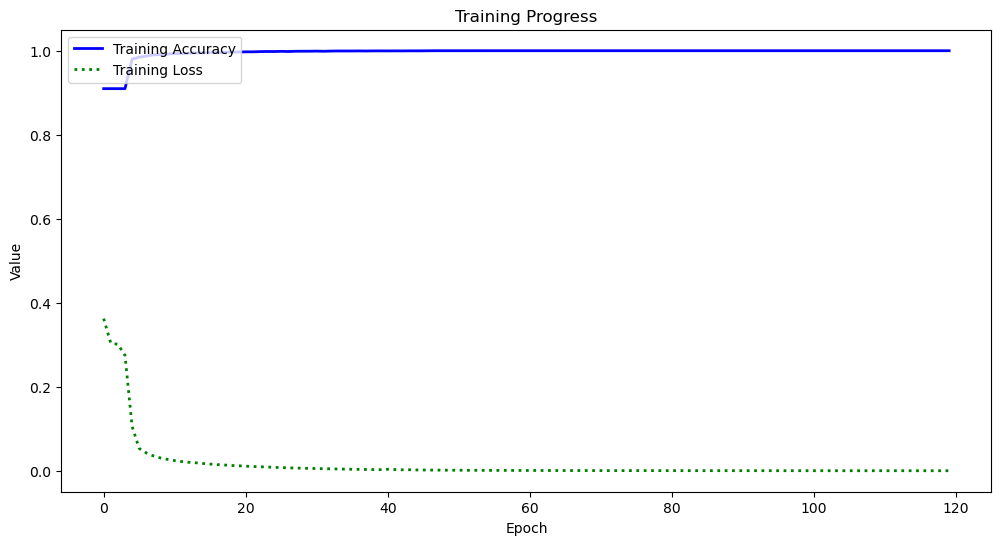

Test Accuracy: 98.19%


In [24]:
train = Train(model, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=120, batch_size=32, normalize=True)
train.execute()

# Evaluate the model on the test set
Y_test_pred = model.forward_propagation(X_test) 
test_accuracy = Train.calculate_accuracy(y_test.reshape(1, -1), Y_test_pred) # Reshape the labels to the correct shape

print(f"Test Accuracy: {test_accuracy*100:.2f}%")